# NLP Assignment 1: Question 5

## Imports

In [1]:
import csv # csv reader

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.classify import SklearnClassifier

from string import punctuation

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score # to report on precision and recall

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Boilerplate Functions

### Parsing Data Lines

In [2]:
def parse_data_line(data_line):
    return (data_line[1], data_line[2])

### Loading Data

In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage, process_func, feature_func):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((feature_func(process_func(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((feature_func(process_func(text)),label))

In [4]:
raw_data = []
data_file_path = "sentiment-dataset.tsv"
load_data(data_file_path)

### Classifier Training and Inference

In [5]:
def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

### Cross Validation

In [6]:
def cross_validate(dataset, folds):
    cv_results = np.array([0,0,0,0])
    fold_results = []
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        train = dataset[:i] + dataset[i+fold_size:]
        test = dataset[i:i+fold_size]
        
        true_vals = [t[1] for t in test]
        
        clf = train_classifier(train)
        preds = predict_labels([x[0] for x in test], clf)
        
        prec, rec, f, _ = precision_recall_fscore_support(true_vals, preds, average="weighted")
        acc = accuracy_score(true_vals, preds)
        result = [prec, rec, f, acc]
        
        cv_results = cv_results + result
        fold_results.append(result)
        
    return cv_results / folds

### Confusion Matrix Heatmap

In [7]:
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

## Preprocessing Functions

In [8]:
def pre_process(text, order=1):
    """
    Remove stopwords and punctuation.
    """
    banned = stopwords.words("english") + list(punctuation)
    
    tokens = text.split()
    tokens = [
        t for t in tokens 
        if t.lower() not in banned
    ]
    tokens = ['<s>'] * (order-1) + tokens + ['</s>']
    return tokens

def pre_process_2(text, order=1):
    """
    Take stem of words.
    """
    banned = stopwords.words("english") + list(punctuation)
    stemmer = PorterStemmer()

    tokens = text.split()
    tokens = [
        stemmer.stem(t) for t in tokens 
        if t.lower() not in banned
    ]
    tokens = ['<s>'] * (order-1) + tokens + ['</s>']
    return tokens
    

def pre_process_3(text, order=1):
    """
    Take lemma of words.
    """
    banned = stopwords.words("english") + list(punctuation)
    lemmatiser = WordNetLemmatizer()

    tokens = text.split()
    tokens = [
        lemmatiser.lemmatize(t) for t in tokens 
        if t.lower() not in banned
    ]
    tokens = ['<s>'] * (order-1) + tokens + ['</s>']
    return tokens

## Feature Extraction Functions

In [9]:
def to_feature_vector(tokens):
    """
    Term frequency
    """
    return {t: tokens.count(t) for t in tokens}

def to_feature_vector_2(tokens):
    """
    Normalised term frequency
    """
    token_len = len(tokens)
    return {
        t: tokens.count(t) / token_len 
        for t in tokens
    }

def to_feature_vector_3(tokens):
    """
    Log of term frequency
    """
    return {
        t: np.log(tokens.count(t)) + 1
        for t in tokens
    }

In [10]:
results = [] # store cross validation results of all techniques

## Technique 1
- **Preprocessing: take tokens as is but remove stopwords and punctuation.**
- **Feature Extraction: take counts of tokens.**

In [11]:
train_data = []
test_data = []
split_and_preprocess_data(0.8, pre_process, to_feature_vector)

In [12]:
# Perform cross validation
cross_val_results = cross_validate(train_data, 10)
results.append(cross_val_results)
cross_val_results

Fold start on items 0 - 2684
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0.81648347, 0.81861527, 0.81684438, 0.81861527])

Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


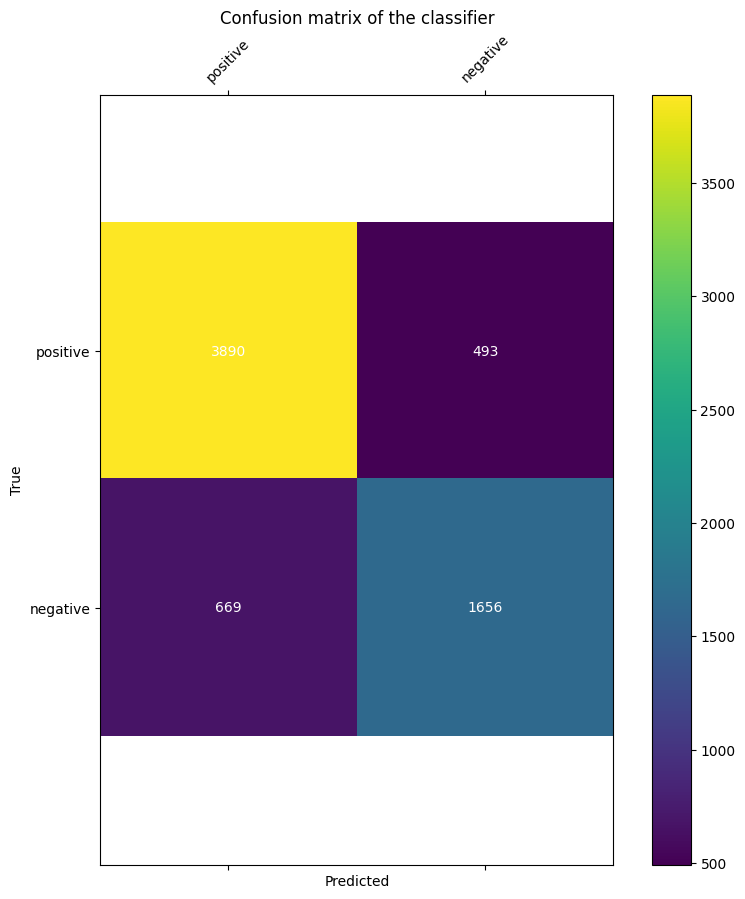

In [13]:
# Run classifier on test set and visualise results
clf = train_classifier(train_data) # training classifier
preds = predict_labels([t[0] for t in test_data], clf) # making prediction on test set
y_true = [t[1] for t in test_data]
confusion_matrix_heatmap(y_true, preds, ["positive", "negative"])

## Technique 2
- **Preprocessing: take tokens as is but remove stopwords and punctuation.**
- **Feature Extraction: take normalised counts of features.**

In [14]:
train_data = []
test_data = []
split_and_preprocess_data(0.8, pre_process, to_feature_vector_2)

In [15]:
# Perform cross validation
cross_val_results = cross_validate(train_data, 10)
results.append(cross_val_results)
cross_val_results

Fold start on items 0 - 2684
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0.81179813, 0.80754613, 0.7948725 , 0.80754613])

Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


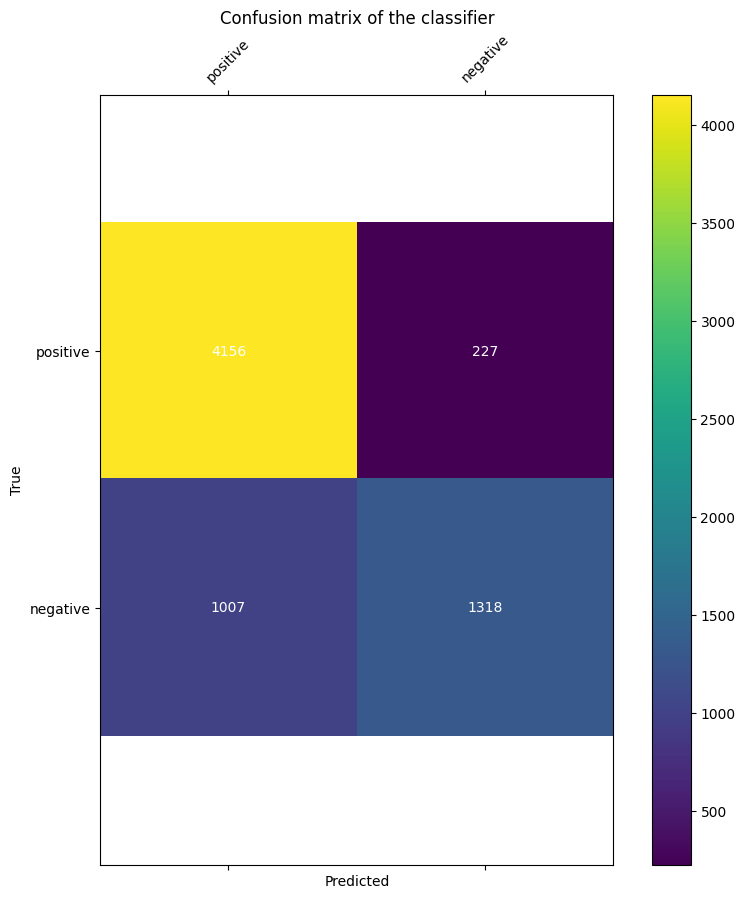

In [16]:
# Run classifier on test set and visualise results
clf = train_classifier(train_data) # training classifier
preds = predict_labels([t[0] for t in test_data], clf) # making prediction on test set
y_true = [t[1] for t in test_data]
confusion_matrix_heatmap(y_true, preds, ["positive", "negative"])

## Technique 3
- **Preprocessing: take tokens as is but remove stopwords and punctuation.**
- **Feature Extraction: take log of counts of tokens.**

In [17]:
train_data = []
test_data = []
split_and_preprocess_data(0.8, pre_process, to_feature_vector_3)

In [18]:
# Perform cross validation
cross_val_results = cross_validate(train_data, 10)
results.append(cross_val_results)
cross_val_results

Fold start on items 0 - 2684
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0.81611595, 0.81831743, 0.81649313, 0.81831743])

Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


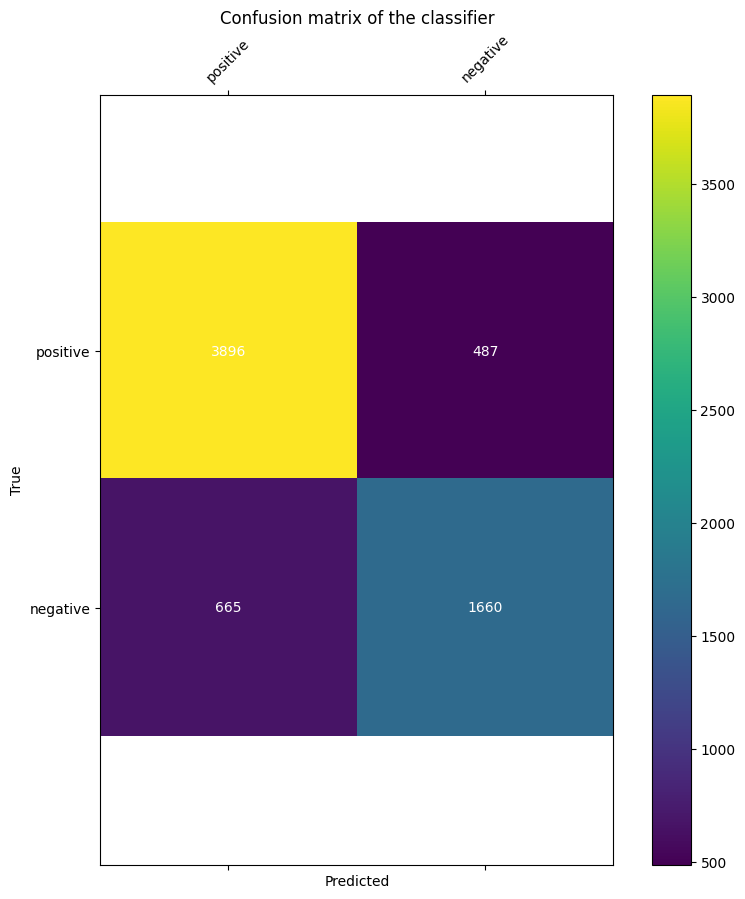

In [19]:
# Run classifier on test set and visualise results
clf = train_classifier(train_data) # training classifier
preds = predict_labels([t[0] for t in test_data], clf) # making prediction on test set
y_true = [t[1] for t in test_data]
confusion_matrix_heatmap(y_true, preds, ["positive", "negative"])

## Technique 4
- **Preprocessing: take stem of tokens and remove stopwords and punctuation.**
- **Feature Extraction: take counts of tokens.**

In [20]:
train_data = []
test_data = []
split_and_preprocess_data(0.8, pre_process_2, to_feature_vector)

In [21]:
# Perform cross validation
cross_val_results = cross_validate(train_data, 10)
results.append(cross_val_results)
cross_val_results

Fold start on items 0 - 2684
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0.82297058, 0.82461255, 0.82337895, 0.82461255])

Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


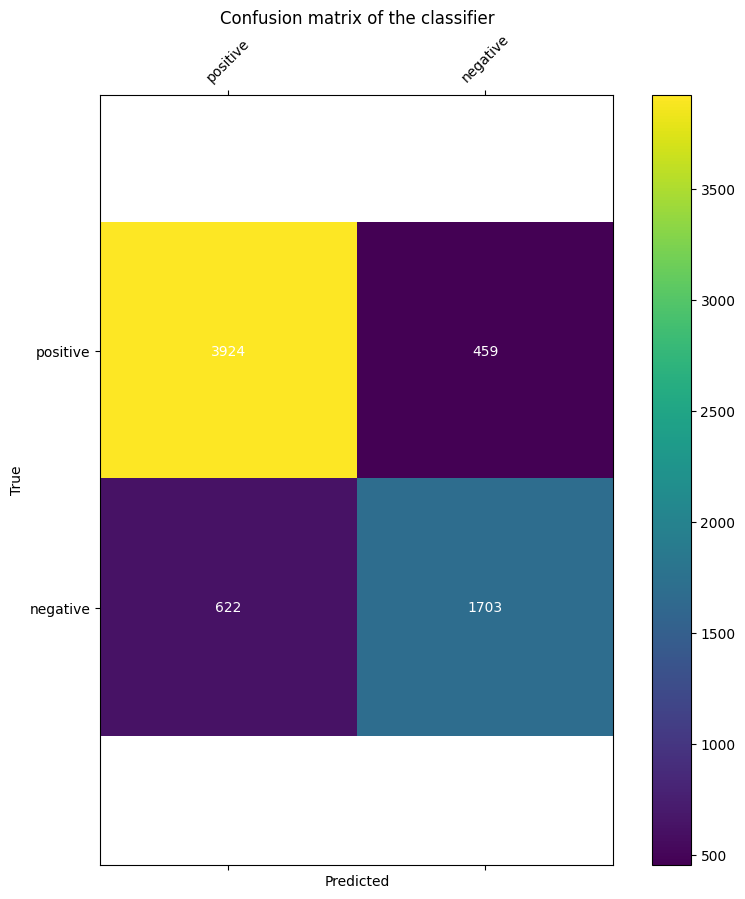

In [22]:
# Run classifier on test set and visualise results
clf = train_classifier(train_data) # training classifier
preds = predict_labels([t[0] for t in test_data], clf) # making prediction on test set
y_true = [t[1] for t in test_data]
confusion_matrix_heatmap(y_true, preds, ["positive", "negative"])

## Technique 5
- **Preprocessing: take stem of tokens and remove stopwords and punctuation.**
- **Feature Extraction: take normalised counts of tokens.**

In [23]:
train_data = []
test_data = []
split_and_preprocess_data(0.8, pre_process_2, to_feature_vector_2)

In [24]:
# Perform cross validation
cross_val_results = cross_validate(train_data, 10)
results.append(cross_val_results)
cross_val_results

Fold start on items 0 - 2684
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0.82788284, 0.82677696, 0.81829019, 0.82677696])

Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


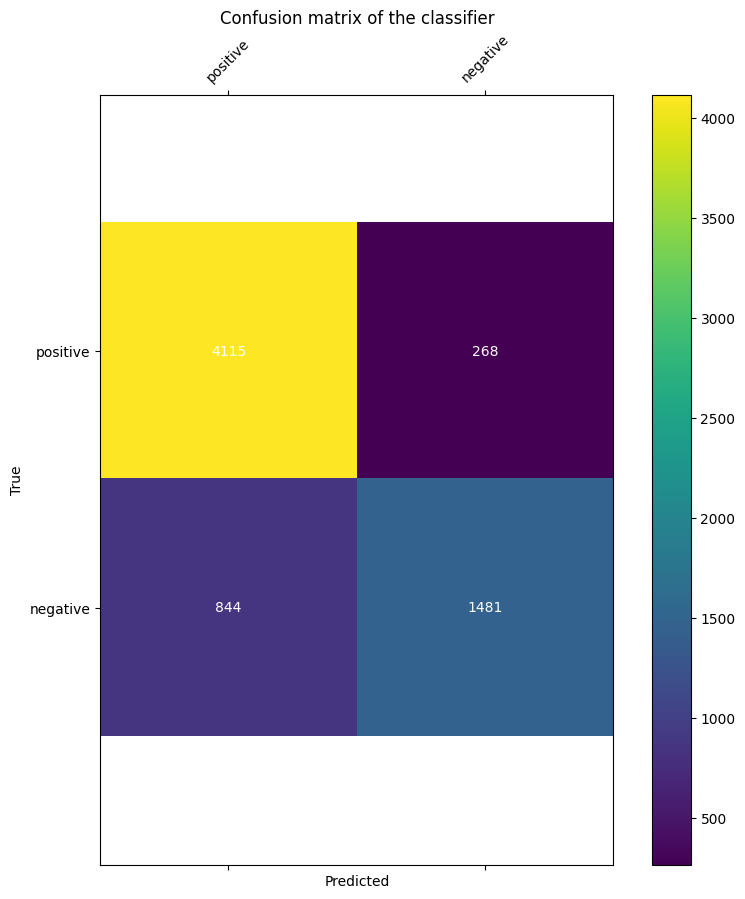

In [25]:
# Run classifier on test set and visualise results
clf = train_classifier(train_data) # training classifier
preds = predict_labels([t[0] for t in test_data], clf) # making prediction on test set
y_true = [t[1] for t in test_data]
confusion_matrix_heatmap(y_true, preds, ["positive", "negative"])

## Technique 6
- **Preprocessing: take stem of tokens and remove stopwords and punctuation.**
- **Feature Extraction: take log of counts of tokens.**

In [26]:
train_data = []
test_data = []
split_and_preprocess_data(0.8, pre_process_2, to_feature_vector_3)

In [27]:
# Perform cross validation
cross_val_results = cross_validate(train_data, 10)
results.append(cross_val_results)
cross_val_results

Fold start on items 0 - 2684
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0.82363686, 0.82520912, 0.82401771, 0.82520912])

Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


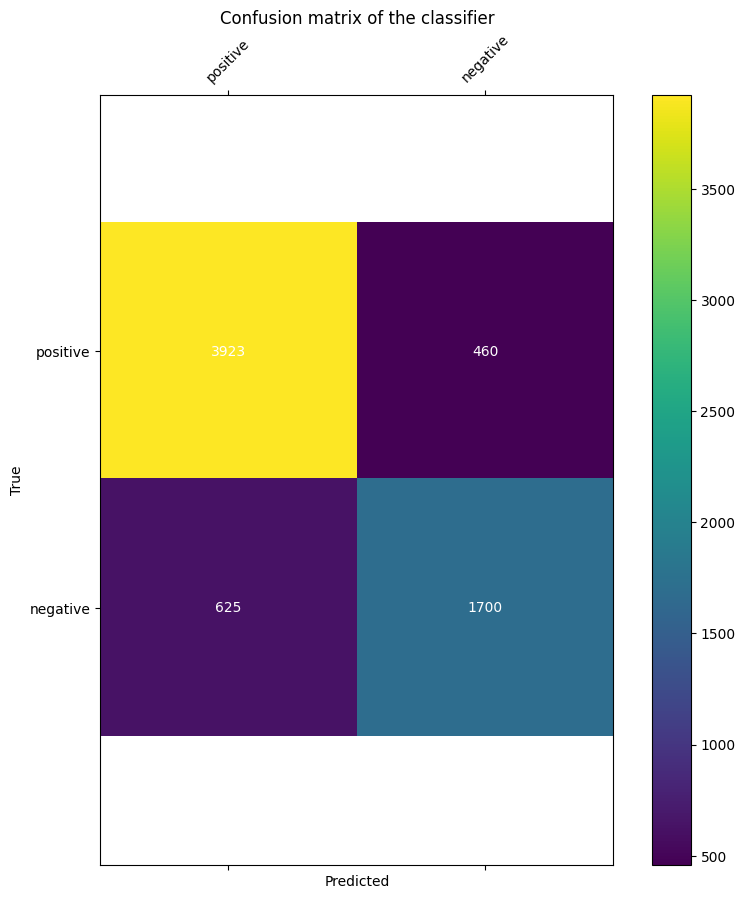

In [28]:
# Run classifier on test set and visualise results
clf = train_classifier(train_data) # training classifier
preds = predict_labels([t[0] for t in test_data], clf) # making prediction on test set
y_true = [t[1] for t in test_data]
confusion_matrix_heatmap(y_true, preds, ["positive", "negative"])

## Technique 7
- **Preprocessing: take lemma of tokens and remove stopwords and punctuation.**
- **Feature Extraction: take counts of features.**

In [29]:
train_data = []
test_data = []
split_and_preprocess_data(0.8, pre_process_3, to_feature_vector)

In [30]:
# Perform cross validation
cross_val_results = cross_validate(train_data, 10)
results.append(cross_val_results)
cross_val_results

Fold start on items 0 - 2684
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0.81823772, 0.82014562, 0.81847072, 0.82014562])

Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


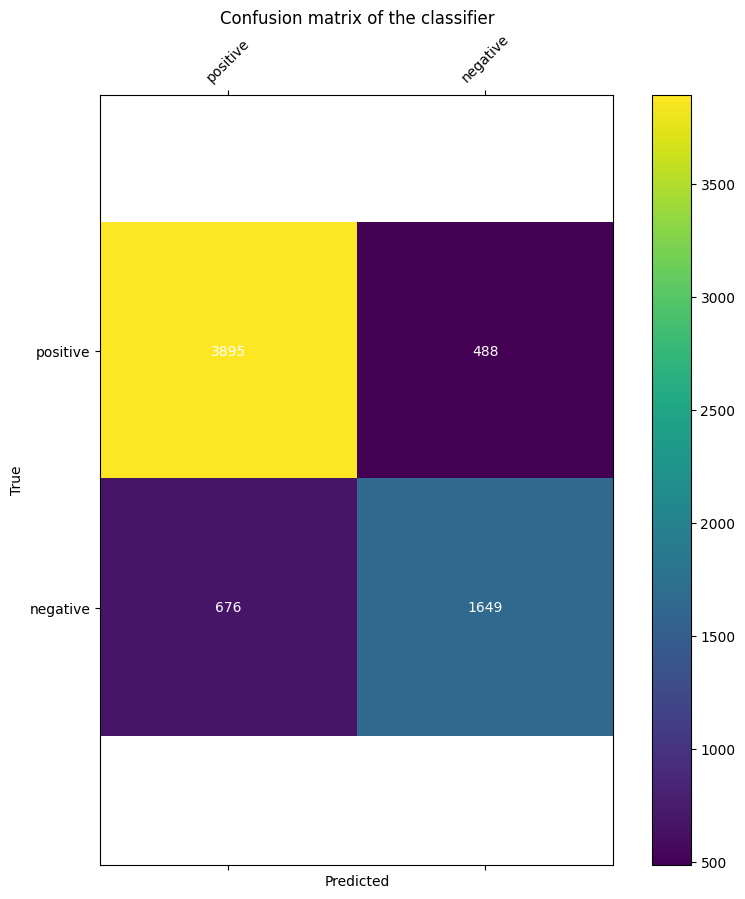

In [31]:
# Run classifier on test set and visualise results
clf = train_classifier(train_data) # training classifier
preds = predict_labels([t[0] for t in test_data], clf) # making prediction on test set
y_true = [t[1] for t in test_data]
confusion_matrix_heatmap(y_true, preds, ["positive", "negative"])

## Technique 8
- **Preprocessing: take lemma of tokens and remove stopwords and punctuation.**
- **Feature Extraction: take normalised counts of tokens.**

In [32]:
train_data = []
test_data = []
split_and_preprocess_data(0.8, pre_process_3, to_feature_vector_2)

In [33]:
# Perform cross validation
cross_val_results = cross_validate(train_data, 10)
results.append(cross_val_results)
cross_val_results

Fold start on items 0 - 2684
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0.81399429, 0.80970731, 0.79744885, 0.80970731])

Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


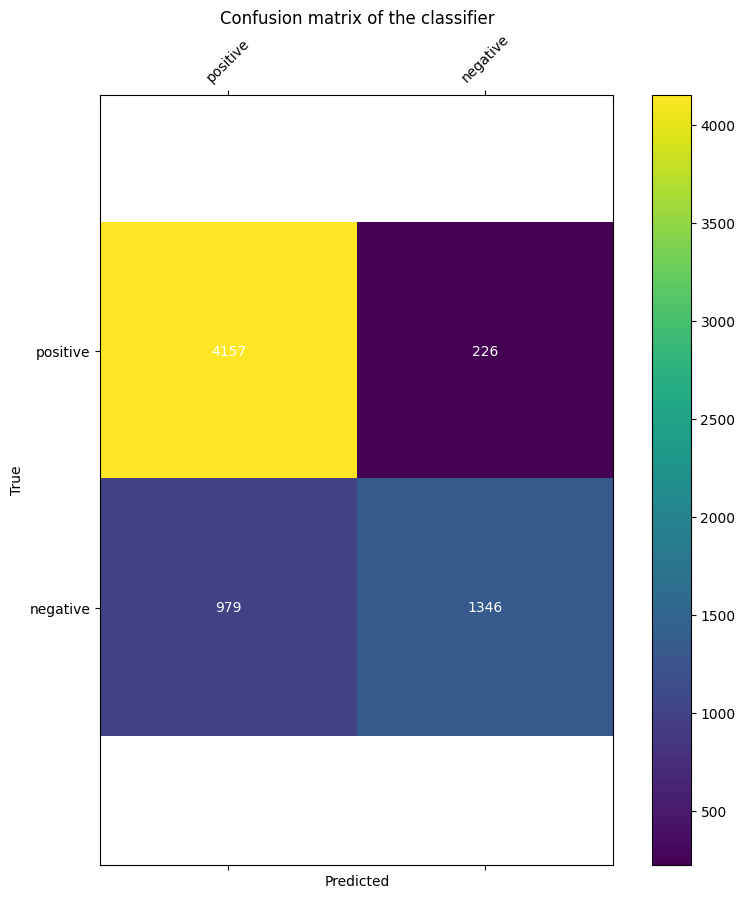

In [34]:
# Run classifier on test set and visualise results
clf = train_classifier(train_data) # training classifier
preds = predict_labels([t[0] for t in test_data], clf) # making prediction on test set
y_true = [t[1] for t in test_data]
confusion_matrix_heatmap(y_true, preds, ["positive", "negative"])

## Technique 9
- **Preprocessing: take lemma of tokens and remove stopwords and punctuation.**
- **Feature Extraction: take log of counts of tokens.**

In [35]:
train_data = []
test_data = []
split_and_preprocess_data(0.8, pre_process_3, to_feature_vector_3)

In [36]:
# Perform cross validation
cross_val_results = cross_validate(train_data, 10)
results.append(cross_val_results)
cross_val_results

Fold start on items 0 - 2684
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0.81899489, 0.82096463, 0.81923811, 0.82096463])

Training Classifier...


/Users/bhekimaenetja/.local/share/virtualenvs/small-projects-ai-NRjJWIjk/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


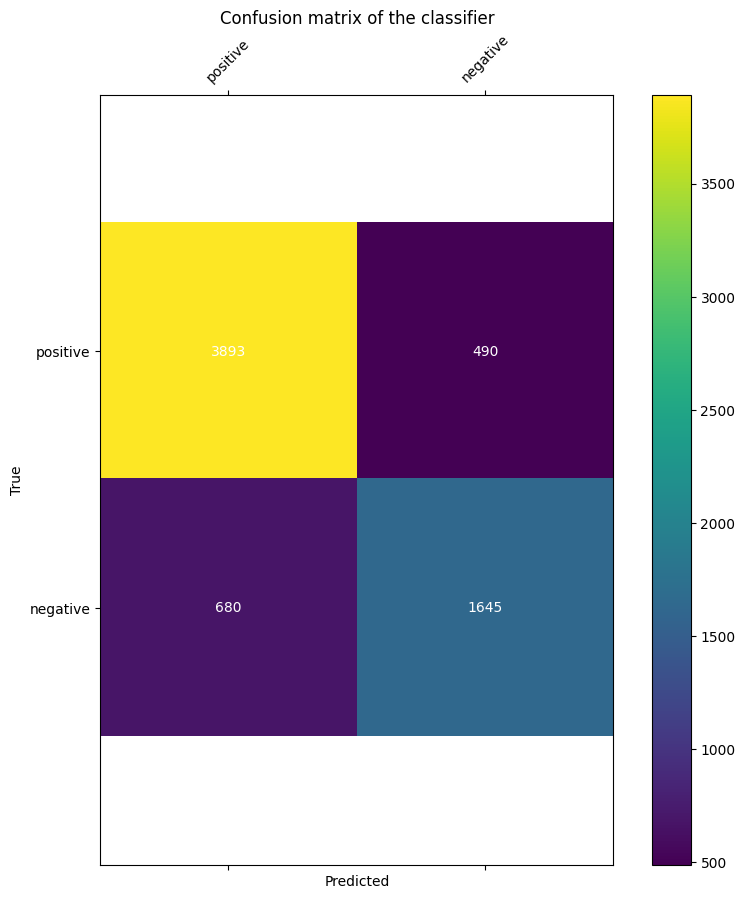

In [37]:
# Run classifier on test set and visualise results
clf = train_classifier(train_data) # training classifier
preds = predict_labels([t[0] for t in test_data], clf) # making prediction on test set
y_true = [t[1] for t in test_data]
confusion_matrix_heatmap(y_true, preds, ["positive", "negative"])

## Summary of Cross Validation Results

In [38]:
techniques = [f"Technique {i+1}" for i in range(9)]
results = np.array(results)

data = {
    "Techniques": techniques,
    "Precision": results[:, 0],
    "Recall": results[:, 1],
    "F-Score": results[:, 2],
    "Accuracy": results[:, 3],
}

table = pd.DataFrame(data=data)
table

,Techniques,Precision,Recall,F-Score,Accuracy
0,Technique 1,0.816483,0.818615,0.816844,0.818615
1,Technique 2,0.811798,0.807546,0.794873,0.807546
2,Technique 3,0.816116,0.818317,0.816493,0.818317
3,Technique 4,0.822971,0.824613,0.823379,0.824613
4,Technique 5,0.827883,0.826777,0.818290,0.826777
5,Technique 6,0.823637,0.825209,0.824018,0.825209
6,Technique 7,0.818238,0.820146,0.818471,0.820146
7,Technique 8,0.813994,0.809707,0.797449,0.809707
8,Technique 9,0.818995,0.820965,0.819238,0.820965
